Matching the CME speed in different position angles, including the lateral expansion, with the deduced radial speeds for type II radio bursts

In [144]:
import warnings
warnings.filterwarnings('ignore')

import os
import glob
import numpy as np
import pandas as pd
from datetime import datetime
import sunpy
from sunpy.map import Map
from sunpy.coordinates import sun
from sunpy.coordinates import frames
from sunpy.sun import constants as const
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.dates import DateFormatter
import astropy.units as u
import astropy.io.fits as fits
import astropy.constants as astro_const
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize, LogStretch, PercentileInterval

# Construct the full path to the scripts directory
script_path = os.path.abspath('./scripts')

# Add the scripts directory to sys.path
import sys
if script_path not in sys.path:
    sys.path.append(script_path)

import fwdtools as fwd
import solar_data_utils as myfuncs
# Reload to update with new changes
import importlib
importlib.reload(fwd)
importlib.reload(myfuncs)

# set the directory path where the data is importe/stored
data_dir = '/home/mnedal/data'

In [10]:
suvi_map_objects  = myfuncs.load_suvi(data_dir=data_dir, start='2024-05-14T17:00:00', end='2024-05-14T18:00:00', channel=195)
clean_suvi_maps   = myfuncs.remove_redundant_maps(suvi_map_objects) # remove redundant images
suvi_seq_runratio = myfuncs.apply_runratio(clean_suvi_maps) # make running ratio maps

for m in suvi_seq_runratio:
    m.plot_settings['norm'] = colors.Normalize(vmin=0.7, vmax=1.3)

SUVI image 0 is done
SUVI image 1 is done
SUVI image 2 is done
SUVI image 3 is done
SUVI image 4 is done
SUVI image 5 is done
SUVI image 6 is done
SUVI image 7 is done
SUVI image 8 is done
SUVI image 9 is done
SUVI image 10 is done
SUVI image 11 is done
SUVI image 12 is done
SUVI image 13 is done
SUVI image 14 is done
SUVI image 15 is done
SUVI image 16 is done
SUVI image 17 is done
SUVI image 18 is done
SUVI image 19 is done
SUVI image 20 is done
SUVI image 21 is done


In [11]:
dates_suvi, distances_suvi, angular_widths_suvi = [], [], []

2025-04-08 14:59:12 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-04-08 14:59:12 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


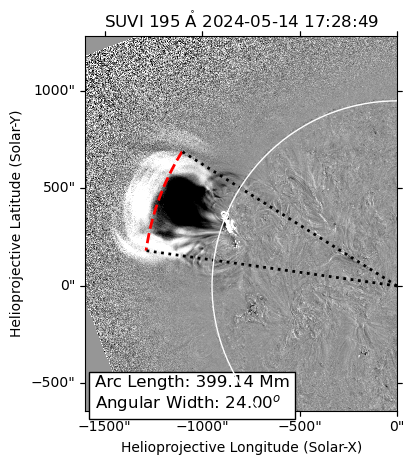

In [142]:
# Define parameters
offset = 350
central_angle = 160

angle_offset = 12          # Half of the total angular width
central_line_length = 950  # Black line length
m = suvi_seq_runratio[6]

fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111, projection=m)
m.plot(axes=ax)
m.draw_limb()
ax.grid(False)

# Get line endpoints
_, upper_end   = myfuncs.plot_line(angle_deg=central_angle - angle_offset, length=central_line_length+offset, map_obj=m)
_, central_end = myfuncs.plot_line(angle_deg=central_angle, length=central_line_length, map_obj=m)
_, lower_end   = myfuncs.plot_line(angle_deg=central_angle + angle_offset, length=central_line_length+offset, map_obj=m)

# Use the black line length as the radius of the arc
radius_arcsec = (central_line_length + offset)*u.arcsec  # Use same radius as the black lines

# Generate arc points centered at the Sun
arc_angles = np.linspace(central_angle-angle_offset, central_angle+angle_offset, 100)  # Smooth arc
arc_x = radius_arcsec * np.cos(np.deg2rad(arc_angles))
arc_y = radius_arcsec * np.sin(np.deg2rad(arc_angles))
arc_coords = SkyCoord(arc_x, arc_y, frame=m.coordinate_frame)

# Compute arc length in Mm
solar_radius_Mm = const.radius.to('Mm').value
rsun_arcsec = m.rsun_obs.value # Solar radius in arcseconds
arc_length_arcsec = radius_arcsec*np.deg2rad(angle_offset*2) # Arc length formula S = Rθ
arc_length_Mm = (arc_length_arcsec/rsun_arcsec).value * solar_radius_Mm # Convert to Mm

# Plot all elements
ax.plot_coord(arc_coords, color='red', linewidth=2, linestyle='dashed') # Correct arc along black lines
ax.plot_coord(SkyCoord([SkyCoord(0*u.arcsec, 0*u.arcsec, frame=m.coordinate_frame), upper_end]), color='black', linewidth=2, linestyle='dotted')
ax.plot_coord(SkyCoord([SkyCoord(0*u.arcsec, 0*u.arcsec, frame=m.coordinate_frame), lower_end]), color='black', linewidth=2, linestyle='dotted')

# Add text annotation
ax.text(0.03, 0.095, f'Arc Length: {arc_length_Mm:.2f} Mm\nAngular Width: {angle_offset*2:.2f}$^o$', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black'))

dates_suvi.append(m.date)
distances_suvi.append(arc_length_Mm)
angular_widths_suvi.append(angle_offset*2)

ax.set_xlim(left=0, right=m.dimensions.x.value/2)
ax.set_ylim(bottom=m.dimensions.y.value*0.3, top=m.dimensions.y.value-m.dimensions.y.value*0.1) # crop 30% from bottom and 10% from top
fig.tight_layout()
plt.show()

2025-04-08 15:38:41 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


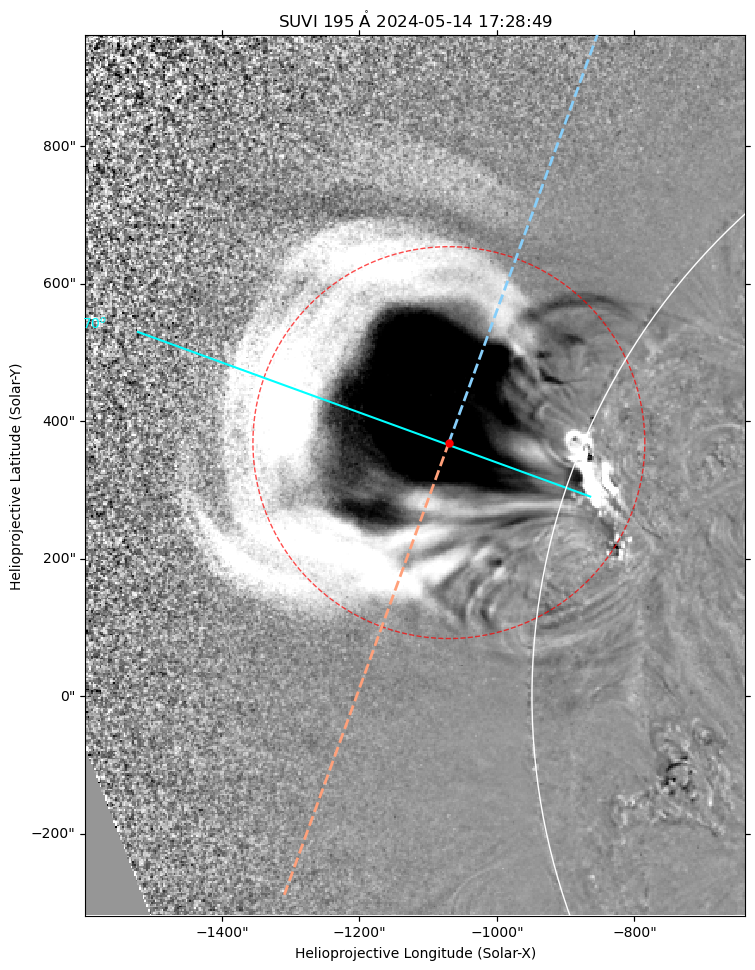

In [173]:
# Define center in HeliographicStonyhurst: N17 = +17°, E72 = -72°
lat = 17 * u.deg      # North
lon = -72 * u.deg     # East is negative in Stonyhurst

# Make SkyCoord for the center in HeliographicStonyhurst
center_hgs = SkyCoord(lon, lat, frame=frames.HeliographicStonyhurst,
                      observer=m.observer_coordinate, obstime=m.date)

# Transform to map coordinate frame (usually Helioprojective)
center_coord = center_hgs.transform_to(m.coordinate_frame)

# Define teh central line across the circle
central_angle       = 160
central_line_length = 700
central_line        = myfuncs.plot_line(angle_deg=central_angle,
                                        length=central_line_length,
                                        start_point=center_coord.Tx.value,
                                        end_point=center_coord.Ty.value,
                                        map_obj=m)
# rename the angles to be position angles, instead of geometric angles
PA_value = central_angle - 90

# Find the y point for the circle's center to intersect with the central line
x1, x2 = central_line.Tx[0].value, central_line.Tx[1].value
y1, y2 = central_line.Ty[0].value, central_line.Ty[1].value

# Linear interpolation
y = y1 + (y2 - y1) / (x2 - x1) * (x.value - x1)

# Define center coordinate (x, y) in arcseconds, e.g., Helioprojective
x = -1070 * u.arcsec
y = y * u.arcsec
r = 285 * u.arcsec  # Radius of the circle

# Define angles to draw the circle
theta = np.linspace(0, 2*np.pi, 500)
circle_x = x + r*np.cos(theta)
circle_y = y + r*np.sin(theta)

# Convert to SkyCoord
circle_coords = SkyCoord(circle_x, circle_y, frame=m.coordinate_frame)
center_coord  = SkyCoord(x, y, frame=m.coordinate_frame)

# Plot map and circle
fig = plt.figure(figsize=[12,20])
ax  = plt.subplot(projection=m)
m.plot(axes=ax)
m.draw_limb()
ax.plot_coord(circle_coords, c='r', ls='--', lw=1, alpha=0.7)
ax.plot_coord(center_coord, c='r', marker='o', ms=5, zorder=20)
ax.plot_coord(central_line, color='cyan', zorder=10)
# Plot the number at the end of the line
# Convert SkyCoord to pixel coordinates for plotting text
line_lon, line_lat = central_line.Tx, central_line.Ty
end_point_pixel = m.world_to_pixel(SkyCoord(line_lon[1], line_lat[1], frame=m.coordinate_frame))
# Display the number at the end point
ax.text(end_point_pixel.x.value-25, end_point_pixel.y.value+5, f'{PA_value}$^o$',
        c='cyan', fontsize=10, ha='center', va='center')
ax.grid(False)

# Plot lateral slits (starting at main slit and extending outward)
upper_flank, lower_flank = myfuncs.lateral_slits(map_obj=m, central_angle=central_angle, slit_length=700, shift_x=x.value, shift_y=y.value)
ax.plot_coord(upper_flank, color='lightskyblue', linewidth=2, linestyle='dashed', zorder=10)
ax.plot_coord(lower_flank, color='lightsalmon', linewidth=2, linestyle='dashed', zorder=10)

# crop 30% from the right
ax.set_xlim(left=0, right=m.dimensions.x.value*0.3)
# crop 40% from the bottom and 20% from the top
ax.set_ylim(bottom=m.dimensions.y.value*0.4, top=m.dimensions.y.value-m.dimensions.y.value*0.2)
fig.tight_layout()
plt.show()

2025-04-08 16:43:35 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


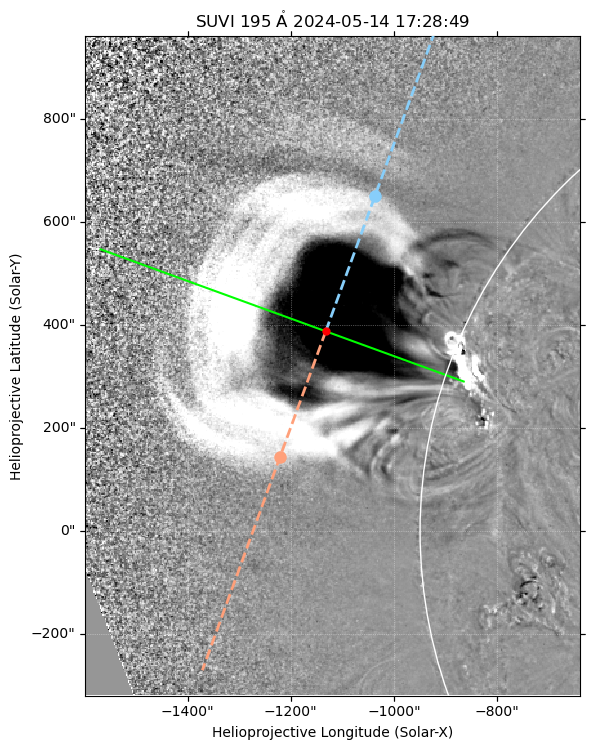

In [215]:
# Test ...

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from sunpy.coordinates import frames

def plot_line(angle_deg=None, length=None, start_point=0, end_point=0, map_obj=None):
    """
    Plot a straight line at an angle in degrees from the solar West.
    """
    angle_rad = np.deg2rad(angle_deg)
    
    # Define the length of the line (in arcseconds)
    line_length = length * u.arcsec
    
    # Define the center point of the line (e.g., the center of the Sun)
    center = SkyCoord(start_point*u.arcsec, end_point*u.arcsec, frame=map_obj.coordinate_frame)
    
    # Calculate the start and end points of the line
    start_point = SkyCoord(center.Tx, center.Ty, frame=map_obj.coordinate_frame)
    end_point   = SkyCoord(center.Tx + line_length * np.cos(angle_rad), 
                           center.Ty + line_length * np.sin(angle_rad),
                           frame=map_obj.coordinate_frame)
    
    line = SkyCoord([start_point, end_point])
    return line

def lateral_slits(map_obj=None, central_angle=160, slit_length=500, shift_x=None, shift_y=None):
    """
    Define two lateral slits perpendicular to a given slit.
    """
    perpendicular_angle = central_angle - 90
    
    # Compute lateral slit start and end points (starting at main slit)
    start_x = shift_x
    start_y = shift_y
    end_x1  = start_x + slit_length * np.cos(np.deg2rad(perpendicular_angle))
    end_y1  = start_y + slit_length * np.sin(np.deg2rad(perpendicular_angle))
    end_x2  = start_x - slit_length * np.cos(np.deg2rad(perpendicular_angle))
    end_y2  = start_y - slit_length * np.sin(np.deg2rad(perpendicular_angle))
    
    # Convert to SkyCoord
    upper_flank = SkyCoord([start_x, end_x1]*u.arcsec, [start_y, end_y1]*u.arcsec, frame=map_obj.coordinate_frame)
    lower_flank = SkyCoord([start_x, end_x2]*u.arcsec, [start_y, end_y2]*u.arcsec, frame=map_obj.coordinate_frame)
    
    return (upper_flank, lower_flank)

# ------------------ MAIN EXECUTION ------------------

# Define center in HeliographicStonyhurst: N17 = +17°, E72 = -72°
lat = 17 * u.deg      # North
lon = -72 * u.deg     # East is negative in Stonyhurst

# Make SkyCoord for the center in HeliographicStonyhurst
center_hgs = SkyCoord(lon, lat, frame=frames.HeliographicStonyhurst,
                      observer=m.observer_coordinate, obstime=m.date)

# Transform to map coordinate frame (usually Helioprojective)
center_coord = center_hgs.transform_to(m.coordinate_frame)

# Define the central line across the circle
central_angle       = 160
central_line_length = 750
central_line        = plot_line(angle_deg=central_angle,
                                length=central_line_length,
                                start_point=center_coord.Tx.value,
                                end_point=center_coord.Ty.value,
                                map_obj=m)

# --- New Section: Place the red circle center at a distance along the central line ---
radial_distance = 285 * u.arcsec  # desired distance from the active region location

angle_rad = np.deg2rad(central_angle)
dx = radial_distance * np.cos(angle_rad)
dy = radial_distance * np.sin(angle_rad)

circle_center = SkyCoord(center_coord.Tx + dx,
                         center_coord.Ty + dy,
                         frame=m.coordinate_frame)

# Define the red circle around this new center
r = 285 * u.arcsec
theta = np.linspace(0, 2*np.pi, 500)
circle_x = circle_center.Tx + r * np.cos(theta)
circle_y = circle_center.Ty + r * np.sin(theta)
circle_coords = SkyCoord(circle_x, circle_y, frame=m.coordinate_frame)



# --- New Section: Plotting the dots along the upper and lower slits ---


# def points_along_lateral_slits(map_obj=None, distance_upper=200, distance_lower=100):
    # return (upper_flank_dot, lower_flank_dot)

# Define the distances from the intersection point along the slits
distance_upper = 280 * u.arcsec  # Distance for upper flank
distance_lower = 260 * u.arcsec  # Distance for lower flank

# Calculate the new coordinates for the upper and lower flank dots
upper_flank, lower_flank = lateral_slits(map_obj=m,
                                         central_angle=central_angle,
                                         slit_length=700,
                                         shift_x=circle_center.Tx.value,
                                         shift_y=circle_center.Ty.value)

# For the upper flank
upper_flank_start_x, upper_flank_start_y = upper_flank.Tx[0].value, upper_flank.Ty[0].value
upper_flank_end_x, upper_flank_end_y = upper_flank.Tx[1].value, upper_flank.Ty[1].value
upper_flank_dx = upper_flank_end_x - upper_flank_start_x
upper_flank_dy = upper_flank_end_y - upper_flank_start_y
upper_flank_dot_x = upper_flank_start_x + distance_upper.value * (upper_flank_dx / np.sqrt(upper_flank_dx**2 + upper_flank_dy**2))
upper_flank_dot_y = upper_flank_start_y + distance_upper.value * (upper_flank_dy / np.sqrt(upper_flank_dx**2 + upper_flank_dy**2))

# For the lower flank
lower_flank_start_x, lower_flank_start_y = lower_flank.Tx[0].value, lower_flank.Ty[0].value
lower_flank_end_x, lower_flank_end_y = lower_flank.Tx[1].value, lower_flank.Ty[1].value
lower_flank_dx = lower_flank_end_x - lower_flank_start_x
lower_flank_dy = lower_flank_end_y - lower_flank_start_y
lower_flank_dot_x = lower_flank_start_x + distance_lower.value * (lower_flank_dx / np.sqrt(lower_flank_dx**2 + lower_flank_dy**2))
lower_flank_dot_y = lower_flank_start_y + distance_lower.value * (lower_flank_dy / np.sqrt(lower_flank_dx**2 + lower_flank_dy**2))

# Convert to SkyCoord
upper_flank_dot = SkyCoord(upper_flank_dot_x * u.arcsec, upper_flank_dot_y * u.arcsec, frame=m.coordinate_frame)
lower_flank_dot = SkyCoord(lower_flank_dot_x * u.arcsec, lower_flank_dot_y * u.arcsec, frame=m.coordinate_frame)




# Plot map and circle
fig = plt.figure(figsize=[6,8])
ax  = plt.subplot(projection=m)
m.plot(axes=ax)
m.draw_limb()

# Plot the red circle and center
# ax.plot_coord(circle_coords, c='r', ls='--', lw=2, alpha=0.7)
ax.plot_coord(circle_center, c='r', marker='o', ms=5, zorder=10)

# Plot the central line
ax.plot_coord(central_line, color='lime')

# Plot lateral slits (starting at red circle center and extending outward)
upper_flank, lower_flank = lateral_slits(map_obj=m,
                                         central_angle=central_angle,
                                         slit_length=700,
                                         shift_x=circle_center.Tx.value,
                                         shift_y=circle_center.Ty.value)

ax.plot_coord(upper_flank, color='lightskyblue', linewidth=2, linestyle='dashed')
ax.plot_coord(lower_flank, color='lightsalmon', linewidth=2, linestyle='dashed')

# Plot the two dots at specific distances
ax.plot_coord(upper_flank_dot, c='lightskyblue', marker='o', ms=8)
ax.plot_coord(lower_flank_dot, c='lightsalmon', marker='o', ms=8)

# crop 30% from the right
ax.set_xlim(left=0, right=m.dimensions.x.value*0.3)
# crop 40% from the bottom and 20% from the top
ax.set_ylim(bottom=m.dimensions.y.value*0.4, top=m.dimensions.y.value-m.dimensions.y.value*0.2)
fig.tight_layout()
plt.show()

In [ ]:
# Test ...

def plot_line(angle_deg=None, length=None, start_point=0, end_point=0, map_obj=None):
    """
    Plot a straight line at an angle in degrees from the solar West.
    """
    angle_rad = np.deg2rad(angle_deg)
    
    # Define the length of the line (in arcseconds)
    line_length = length * u.arcsec
    
    # Define the center point of the line (e.g., the center of the Sun)
    center = SkyCoord(start_point*u.arcsec, end_point*u.arcsec, frame=map_obj.coordinate_frame)
    
    # Calculate the start and end points of the line
    start_point = SkyCoord(center.Tx, center.Ty, frame=map_obj.coordinate_frame)
    end_point   = SkyCoord(center.Tx + line_length * np.cos(angle_rad), 
                           center.Ty + line_length * np.sin(angle_rad),
                           frame=map_obj.coordinate_frame)
    
    line = SkyCoord([start_point, end_point])
    return line


def lateral_slits(map_obj=None, central_angle=160, slit_length=500, shift_x=None, shift_y=None):
    """
    Define two lateral slits perpendicular to a given slit.
    """
    perpendicular_angle = central_angle - 90
    
    # Compute lateral slit start and end points (starting at main slit)
    start_x = shift_x
    start_y = shift_y
    end_x1  = start_x + slit_length * np.cos(np.deg2rad(perpendicular_angle))
    end_y1  = start_y + slit_length * np.sin(np.deg2rad(perpendicular_angle))
    end_x2  = start_x - slit_length * np.cos(np.deg2rad(perpendicular_angle))
    end_y2  = start_y - slit_length * np.sin(np.deg2rad(perpendicular_angle))
    
    # Convert to SkyCoord
    upper_flank = SkyCoord([start_x, end_x1]*u.arcsec, [start_y, end_y1]*u.arcsec, frame=map_obj.coordinate_frame)
    lower_flank = SkyCoord([start_x, end_x2]*u.arcsec, [start_y, end_y2]*u.arcsec, frame=map_obj.coordinate_frame)
    
    return (upper_flank, lower_flank)


# Define center in HeliographicStonyhurst: N17 = +17°, E72 = -72°
lat = 17 * u.deg      # North
lon = -72 * u.deg     # East is negative in Stonyhurst

# Make SkyCoord for the center in HeliographicStonyhurst
center_hgs = SkyCoord(lon, lat, frame=frames.HeliographicStonyhurst,
                      observer=m.observer_coordinate, obstime=m.date)

# Transform to map coordinate frame (usually Helioprojective)
center_coord = center_hgs.transform_to(m.coordinate_frame)

# Define teh central line across the circle
central_angle       = 160
central_line_length = 700
central_line        = plot_line(angle_deg=central_angle,
                                        length=central_line_length,
                                        start_point=center_coord.Tx.value,
                                        end_point=center_coord.Ty.value,
                                        map_obj=m)
# rename the angles to be position angles, instead of geometric angles
PA_value = central_angle - 90

# Find the y point for the circle's center to intersect with the central line
x1, x2 = central_line.Tx[0].value, central_line.Tx[1].value
y1, y2 = central_line.Ty[0].value, central_line.Ty[1].value

# Linear interpolation
y = y1 + (y2 - y1) / (x2 - x1) * (x.value - x1)

# Define center coordinate (x, y) in arcseconds, e.g., Helioprojective
x = -1150 * u.arcsec
y = y * u.arcsec
r = 290 * u.arcsec  # Radius of the circle

# Define angles to draw the circle
theta = np.linspace(0, 2*np.pi, 500)
circle_x = x + r*np.cos(theta)
circle_y = y + r*np.sin(theta)

# Convert to SkyCoord
circle_coords = SkyCoord(circle_x, circle_y, frame=m.coordinate_frame)
center_coord  = SkyCoord(x, y, frame=m.coordinate_frame)

# Plot map and circle
fig = plt.figure(figsize=[10,15])
ax  = plt.subplot(projection=m)
m.plot(axes=ax)
ax.plot_coord(circle_coords, c='r', ls='--', lw=2)
ax.plot_coord(center_coord, c='r', marker='o', ms=5)
ax.plot_coord(central_line, color='cyan')

# Plot lateral slits (starting at main slit and extending outward)
upper_flank, lower_flank = lateral_slits(map_obj=m, central_angle=central_angle, slit_length=700, shift_x=x.value, shift_y=y.value)
ax.plot_coord(upper_flank, color='lightskyblue', linewidth=2, linestyle='dashed')
ax.plot_coord(lower_flank, color='lightsalmon', linewidth=2, linestyle='dashed')

plt.show()

In [154]:
def intersection_with_circle(x0, y0, x1, y1, cx, cy, r):
    """
    Find intersection(s) between a line (x0,y0)->(x1,y1) and a circle centered at (cx,cy) with radius r.
    Returns closest intersection point to (x0,y0).
    """
    dx = x1 - x0
    dy = y1 - y0

    a = dx**2 + dy**2
    b = 2 * (dx * (x0 - cx) + dy * (y0 - cy))
    c = (x0 - cx)**2 + (y0 - cy)**2 - r**2

    discriminant = b**2 - 4*a*c

    if discriminant < 0:
        return None  # No intersection

    sqrt_disc = np.sqrt(discriminant)

    t1 = (-b + sqrt_disc) / (2*a)
    t2 = (-b - sqrt_disc) / (2*a)

    # Calculate intersection points
    inter1 = (x0 + t1 * dx, y0 + t1 * dy)
    inter2 = (x0 + t2 * dx, y0 + t2 * dy)

    # Choose the one closer to the start point (x0, y0)
    d1 = np.hypot(inter1[0] - x0, inter1[1] - y0)
    d2 = np.hypot(inter2[0] - x0, inter2[1] - y0)

    if d1 < d2:
        return inter1, d1
    else:
        return inter2, d2

In [156]:
# Upper flank start and end points
uf_x = upper_flank.Tx.to_value(u.arcsec)
uf_y = upper_flank.Ty.to_value(u.arcsec)

# Lower flank start and end points
lf_x = lower_flank.Tx.to_value(u.arcsec)
lf_y = lower_flank.Ty.to_value(u.arcsec)

# Circle center and radius
cx = x.to_value(u.arcsec)
cy = y.to_value(u.arcsec)
radius = r.to_value(u.arcsec)

# Upper flank
(uf_ix, uf_iy), upper_len = intersection_with_circle(uf_x[0], uf_y[0], uf_x[1], uf_y[1], cx, cy, radius)

# Lower flank
(lf_ix, lf_iy), lower_len = intersection_with_circle(lf_x[0], lf_y[0], lf_x[1], lf_y[1], cx, cy, radius)

print(f'Upper flank length until circle intersection: {upper_len:.2f} arcsec')
print(f'Lower flank length until circle intersection: {lower_len:.2f} arcsec')

Upper flank length until circle intersection: 290.00 arcsec
Lower flank length until circle intersection: 290.00 arcsec


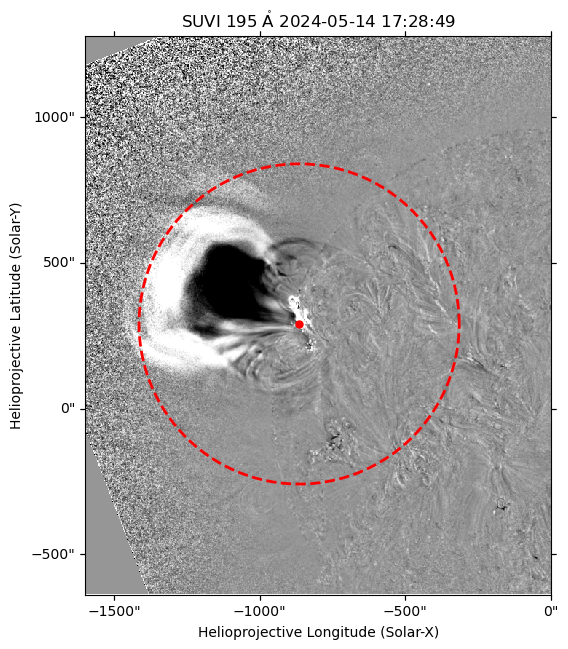

In [63]:
# Define center in HeliographicStonyhurst: N17 = +17°, E72 = -72°
lat = 17 * u.deg      # North
lon = -72 * u.deg     # East is negative in Stonyhurst
r   = 550 * u.arcsec  # Radius of circle

# Make SkyCoord for the center in HeliographicStonyhurst
center_hgs = SkyCoord(lon, lat, frame=frames.HeliographicStonyhurst,
                      observer=m.observer_coordinate, obstime=m.date)

# Transform to map coordinate frame (usually Helioprojective)
center_coord = center_hgs.transform_to(m.coordinate_frame)

# Generate circle in helioprojective coordinates
theta = np.linspace(0, 2*np.pi, 500)
circle_x = center_coord.Tx + r*np.cos(theta)
circle_y = center_coord.Ty + r*np.sin(theta)
circle_coords = SkyCoord(circle_x, circle_y, frame=m.coordinate_frame)

# Plot map and circle
fig = plt.figure(figsize=[10,10])
ax = plt.subplot(projection=m)
m.plot(axes=ax)
ax.plot_coord(circle_coords, c='r', ls='--', lw=2)
ax.plot_coord(center_coord, c='r', marker='o', ms=5)
ax.grid(False)
ax.set_xlim(left=0, right=m.dimensions.x.value/2)
ax.set_ylim(bottom=m.dimensions.y.value*0.3, top=m.dimensions.y.value-m.dimensions.y.value*0.1) # crop 30% from bottom and 10% from top
fig.tight_layout()
plt.show()

In [3]:
# Type II burst lanes with their radial velocities
type_II_bursts = [
    ('1 LF', 1227.51), ('1 LH', 1224.16), ('1 UF', 546.37), ('1 UH', 632.60),
    ('2 F', 810.06), ('2 H', 816.65),
    ('3 LF', 553.15), ('3 LH', 709.25), ('3 MF', 443.09), ('3 MH', 480.89), ('3 UF', 497.91), ('3 UH', 568.12),
    ('4 F', 1939.38), ('4 H', 2075.31)
]

In [7]:
# CME fitted results
fit_df_suvi = pd.read_csv(f'{data_dir}/euv_speeds_suvi.csv')
CME_fit_data = fit_df_suvi[['PA','v0_km/s','v_min_km/s','v_max_km/s','v_mean_km/s']]
CME_fit_data['upper_flank'] = 0
CME_fit_data['lower_flank'] = 0
CME_fit_data

,PA,v0_km/s,v_min_km/s,v_max_km/s,v_mean_km/s,upper_flank,lower_flank
0,58.0,159.37,159.37,620.26,388.95,0,0
1,60.0,917.20,917.20,517.30,716.75,0,0
2,62.0,466.69,466.69,531.30,498.98,0,0
3,64.0,148.52,148.52,591.63,372.87,0,0
4,66.0,176.78,176.78,567.52,371.36,0,0
5,68.0,222.66,222.66,490.05,355.17,0,0
6,70.0,100.00,100.00,407.00,254.99,0,0
7,72.0,215.54,215.54,399.46,308.51,0,0
8,74.0,208.06,208.06,389.97,299.86,0,0
9,76.0,137.72,137.72,444.32,293.31,0,0


In [8]:
# Find the closest PA for each Type II burst lane
results = []
for lane, radial_velocity in type_II_bursts:
    closest_idx = (CME_fit_data['v_mean_km/s'] - radial_velocity).abs().idxmin()
    closest_pa = CME_fit_data.loc[closest_idx, 'PA']
    closest_v_mean = CME_fit_data.loc[closest_idx, 'v_mean_km/s']
    results.append((lane, radial_velocity, closest_pa, closest_v_mean))

# Convert results to DataFrame
match_results = pd.DataFrame(results, columns=['Type II Lane', 'Radial Velocity (km/s)', 'Closest PA', 'Closest v_mean_km/s'])
match_results

,Type II Lane,Radial Velocity (km/s),Closest PA,Closest v_mean_km/s
0,1 LF,1227.51,60.0,716.75
1,1 LH,1224.16,60.0,716.75
2,1 UF,546.37,62.0,498.98
3,1 UH,632.60,60.0,716.75
4,2 F,810.06,60.0,716.75
5,2 H,816.65,60.0,716.75
6,3 LF,553.15,62.0,498.98
7,3 LH,709.25,60.0,716.75
8,3 MF,443.09,78.0,459.14
9,3 MH,480.89,80.0,494.96
